# GANS for Generating MNIST Data

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten , BatchNormalization,LeakyReLU
from tensorflow.keras.datasets import mnist

Shape of the MNIST dataset image.

In [2]:
img_rows = 28
img_cols = 28 
channels = 1
img_shape = (img_rows,img_cols,channels)

**Building a Generator Model**

In [3]:
def build_generator():
  noise_shape = (100,)
  inp = tf.keras.Input(shape=noise_shape)
  x = Dense(256)(inp)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(512)(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(1024)(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(np.prod(img_shape),activation="tanh")(x)
  x = Reshape(img_shape)(x)
  model = tf.keras.Model(inputs=inp,outputs=x)
  model.build(input_shape=noise_shape)
  return model

In [4]:
gen = build_generator()
gen.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048  

**Building a Discriminator Model**

In [5]:
def build_discriminator():
  inp = tf.keras.Input(shape=img_shape)
  x = Flatten()(inp)
  x = Dense(512)(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = Dense(512)(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = Dense(1,activation="sigmoid")(x)
  model = tf.keras.Model(inputs=inp,outputs=x)
  model.build(input_shape=img_shape)
  return model

In [6]:
disc = build_discriminator()
disc.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513 

**Saving Images during training**

In [7]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = gen.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("/content/mnist_%d.png" % epoch)
    plt.close()
#This function saves our images for us to view

**Training Loop for the neural network**

In [8]:
def train(epochs,batch_size=128,save_interval=10):
  (X_train,_),(_,_) = mnist.load_data()
  X_train = (X_train.astype(np.float32)-127.5)/127.5
  X_train = np.expand_dims(X_train,axis=3)
  half_batch = int(batch_size/2)
  for epoch in range(epochs):
    idx = np.random.randint(0,X_train.shape[0],half_batch)
    imgs = X_train[idx]
    noise = np.random.normal(0, 1, (half_batch, 100))
    gen_imgs = gen.predict(noise)

  # Loss Functions 
  # We will train the Discriminator on Real and Fake images respectively 

    d_loss_real = disc.train_on_batch(imgs,np.ones((half_batch,1)))
    d_loss_fake = disc.train_on_batch(gen_imgs,np.zeros((half_batch,1)))
    d_loss = 0.5*np.add(d_loss_real,d_loss_fake)


    noise = np.random.normal(0, 1, (batch_size, 100))
    valid_y = np.array([1] * batch_size)
    g_loss = combined.train_on_batch(noise, valid_y)

    if epoch % save_interval == 0:
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
      save_imgs(epoch)

**Training Parameters**

In [9]:
optimizer = tf.keras.optimizers.Adam(0.0002,0.5)
disc.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])
gen.compile(loss='binary_crossentropy', optimizer=optimizer)
disc.trainable = False  

In [10]:
z = tf.keras.Input(shape=(100,)) 
img = gen(z)
valid = disc(img)
combined = tf.keras.Model(z,valid)
combined.compile(loss="binary_crossentropy",optimizer=optimizer)
train(epochs=10000, batch_size=32, save_interval=1000)
gen.save("generator_model.h5")

11493376/11490434 [==============================] - 0s 0us/step
0 [D loss: 0.724844, acc.: 40.62%] [G loss: 0.484210]
1000 [D loss: 0.664324, acc.: 65.62%] [G loss: 0.852501]
2000 [D loss: 0.604068, acc.: 59.38%] [G loss: 1.040050]
3000 [D loss: 0.591423, acc.: 71.88%] [G loss: 1.051820]
4000 [D loss: 0.867556, acc.: 43.75%] [G loss: 0.972427]
5000 [D loss: 0.736257, acc.: 56.25%] [G loss: 0.934479]
6000 [D loss: 0.715711, acc.: 56.25%] [G loss: 0.975323]
7000 [D loss: 0.651646, acc.: 65.62%] [G loss: 0.845851]
8000 [D loss: 0.668057, acc.: 62.50%] [G loss: 0.952610]
9000 [D loss: 0.648395, acc.: 65.62%] [G loss: 0.909050]


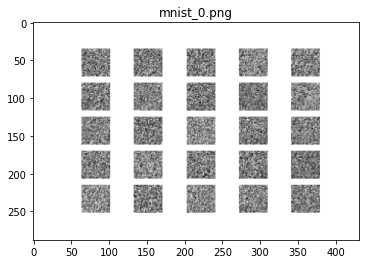

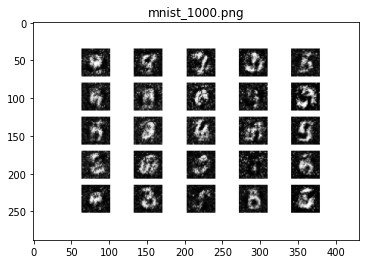

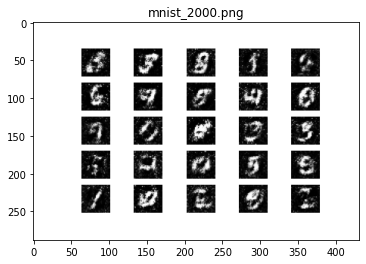

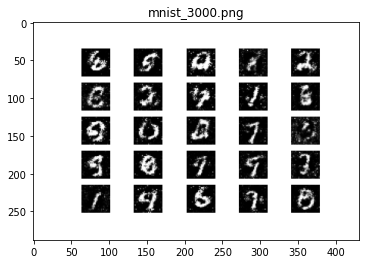

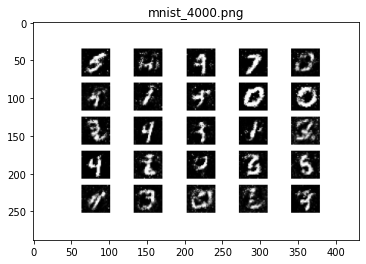

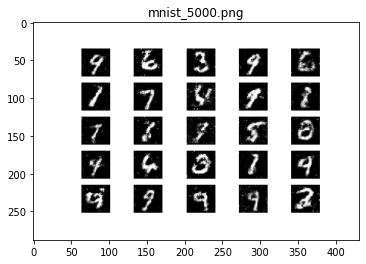

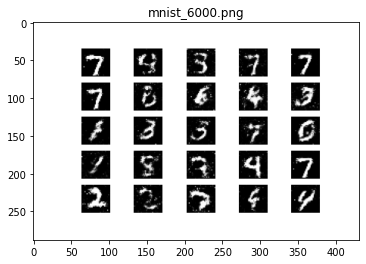

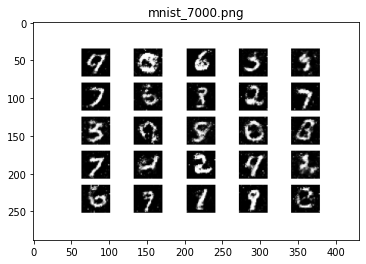

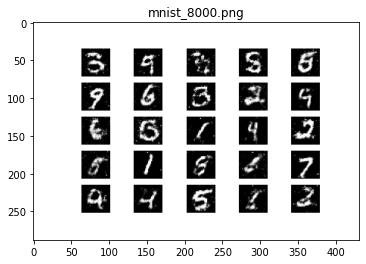

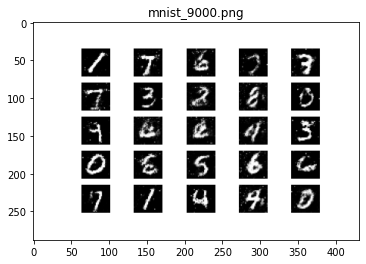

In [24]:
import os
import cv2
for i in sorted(os.listdir()):
  if "png" in i:
    img = cv2.imread(i)
    plt.title(i)
    plt.imshow(img)
    plt.show()
